In [18]:
import sys
import rospy
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import pandas as pd

sys.path.insert(0, '/home/lucas/Documents/EESC_Linux/Drone_project/sarc/SARC2022/python/uav')

from uav import UAV
from sensors.gps import uavGPS
from sensors.camera import uavCamera

In [19]:
uav_t = UAV(uav_id = '0')

[INFO] [1655243791.895453]: UAV0 INIT SUCCEEDED


In [20]:
#BGR -> RGB
def to_rgb(cv_img):
    rgb_img = cv2.cvtColor(cv_img, cv2.COLOR_BGR2RGB)
    return rgb_img

def img_show(img, title = None):
    
    plt.figure(figsize=(12,8))
    if title is not None:
        plt.title(title)

    plt.imshow(to_rgb(img))

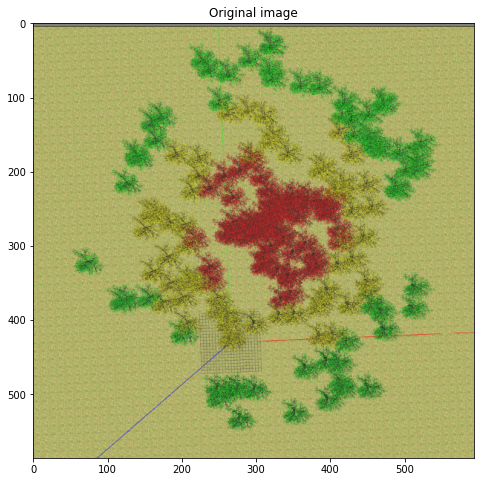

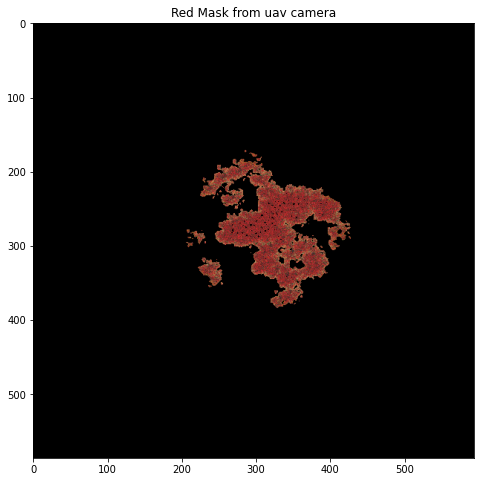

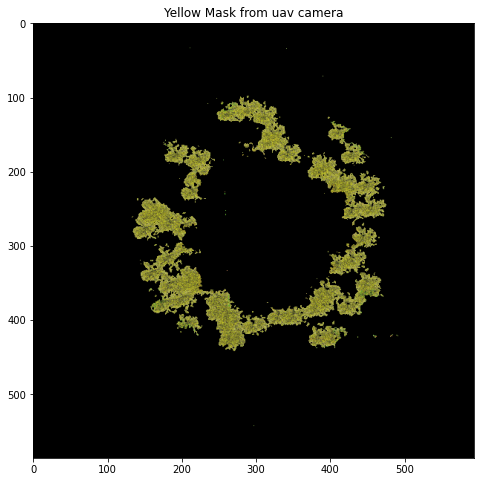

In [21]:
frame = cv2.imread("./scene_01.jpeg")
uav_t.camera.color_detection(img_src = frame)

img_show(frame, "Original image")
img_show(uav_t.camera.cv_img_masked_red, title = 'Red Mask from uav camera')
img_show(uav_t.camera.cv_img_masked_yellow, title = 'Yellow Mask from uav camera')

In [22]:
#bounding box
red_mask = uav_t.camera.mask_red
yellow_mask = uav_t.camera.mask_yellow

xmin, ymin, xmax, ymax = uav_t.camera.bounding_box_vertices(img_mask = red_mask)


xbox_vertices = np.array([xmin, xmin, xmax, xmax])
ybox_vertices = np.array([ymin, ymax, ymin, ymax])

X, Y = uav_t.camera.estimate_3d_coordinates(x_pixel = xbox_vertices,
                                            y_pixel = ybox_vertices,
                                            z_gps = 100)

#Red area
X_red, Y_red = uav_t.camera.estimate_3d_coordinates(x_pixel = np.nonzero(red_mask)[1],
                                                    y_pixel = np.nonzero(red_mask)[0],
                                                    z_gps = 100)
#Yellow area
X_yellow, Y_yellow = uav_t.camera.estimate_3d_coordinates(x_pixel = np.nonzero(yellow_mask)[1],
                                                    y_pixel = np.nonzero(yellow_mask)[0],
                                                    z_gps = 100)

rx = int(0.5*(max(X) - min(X)))
ry = int(0.5*(max(Y) - min(Y)))
r_trajectory = max(rx, ry)   
x_center, y_center = np.mean(X), np.mean(Y)


xs_trajectory, ys_trajectory = uav_t.gps.circular_trajectory_pts(x_center = x_center,
                                                                y_center = y_center,
                                                                radius = 1.05*r_trajectory,
                                                                num_of_pts = 12)


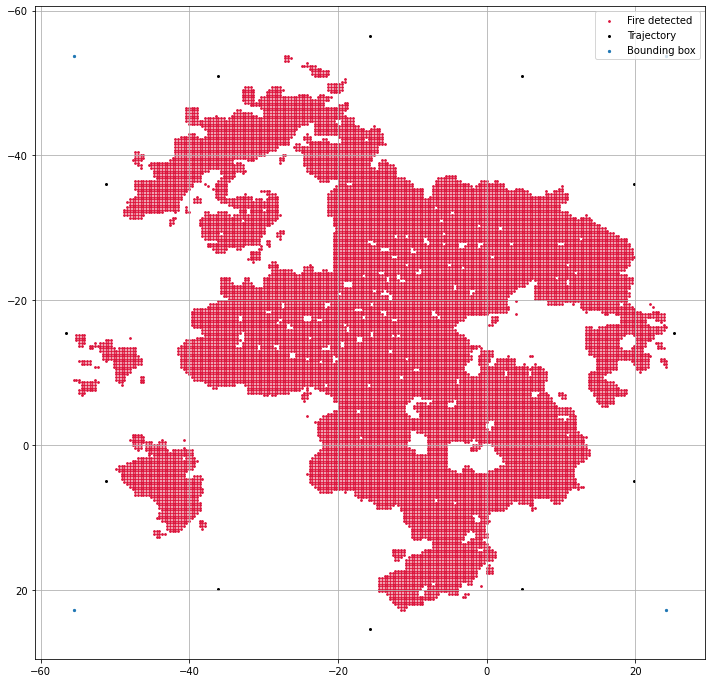

In [23]:
fig2d = plt.figure(figsize = (12,12))
plt.gca().invert_yaxis()

plt.scatter(X_red, Y_red, color = 'crimson', s = 3, label='Fire detected')
plt.scatter(xs_trajectory, ys_trajectory, color = 'black', s = 4, label='Trajectory')
plt.scatter(X, Y, s = 5, label='Bounding box')

plt.grid()
plt.legend()
plt.show()
#! Tá errado isso aqui!

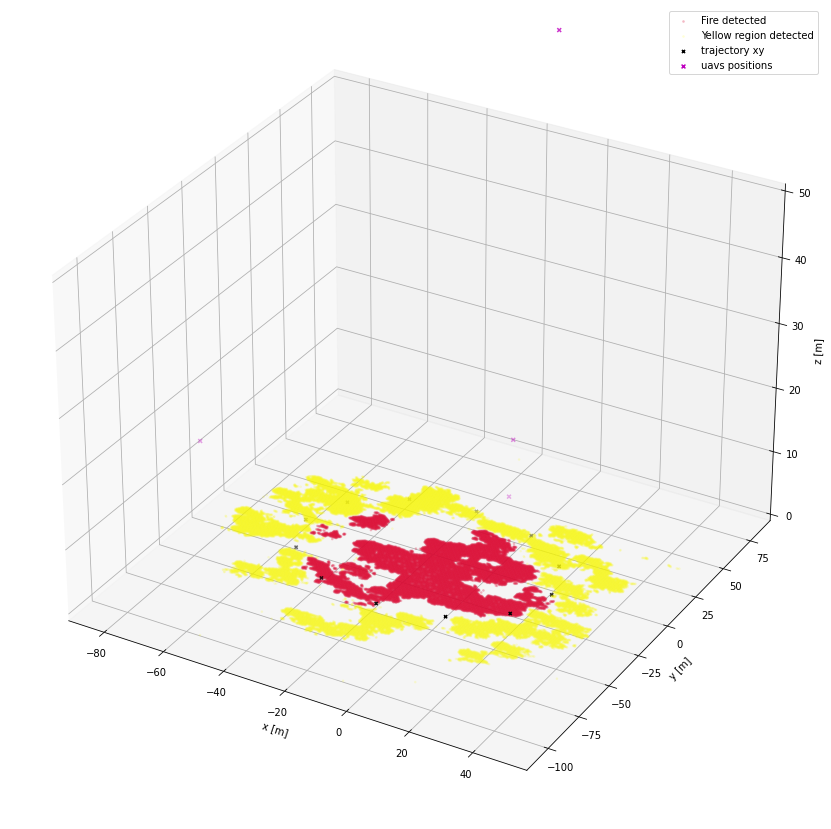

In [27]:
fig = plt.figure(figsize=(20,15))
ax = fig.add_subplot(111, projection='3d')

#Fire (red) detected
fire = ax.scatter(X_red, Y_red, np.zeros_like(X_red), c = 'crimson', s = 3, label = 'Fire detected', alpha = 0.2)

#Yellow region
yellow = ax.scatter(X_yellow, Y_yellow, np.zeros_like(X_yellow), c = 'yellow', s = 3, label = 'Yellow region detected', alpha = 0.1)

#Trajectory points
trajectory_pts = ax.scatter(xs_trajectory, ys_trajectory, 2*np.ones_like(xs_trajectory),
                            c = 'black', s = 10, label = "trajectory xy", marker = 'x')

#Uav random positions
uavs_x_pos = np.random.randn(5) * 50
uavs_y_pos = np.random.randn(5) * 50
uavs_z_pos = abs(np.random.randn(5)) * 50

uav_random_positions = ax.scatter(  uavs_x_pos, uavs_y_pos, uavs_z_pos, c = 'm', 
                                    label='uavs positions', marker = 'x', s=15)

ax.set_xlabel('x [m]')
ax.set_ylabel('y [m]')
ax.set_zlabel('z [m]')
ax.set_zlim([0,50])
plt.legend()
plt.show()

In [41]:
#distancias de cada drone em relacao aos pts da trajetoria
dx = np.tile(uavs_x_pos, (len(xs_trajectory), 1)).T - xs_trajectory
dy = np.tile(uavs_y_pos, (len(ys_trajectory), 1)).T - ys_trajectory

distances = np.sqrt(dx**2 +dy**2)

In [ ]:

#TODO: estabeler uma política de tomada de decisão, a qual atribui a cada drone
#disponível uma coordenada da trajetória. Podemos utilizar tomar como base para 
#a tomada de decisão o mínimo gasto energético. Ou, de forma mais simplificada,
#atribuir a cada uav o ponto da trajetória que estimar mais próximo.